In [3]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
import chaospy


In [6]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


######################### TO DO ####################################


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


################################################################
#  2d fourier layer
################################################################
# class SpectralConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, modes1, modes2):
#         super(SpectralConv2d, self).__init__()

#         """
#         2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
#         """

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
#         self.modes2 = modes2

#         self.scale = (1 / (in_channels * out_channels))
#         self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
#         self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

#     # Complex multiplication
#     def compl_mul2d(self, input, weights):
#         # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
#         return torch.einsum("bixy,ioxy->boxy", input, weights)

#     def forward(self, x):
#         batchsize = x.shape[0]
#         # Compute Fourier coeffcients up to factor of e^(- something constant)
#         x_ft = torch.fft.rfft2(x)

#         # Multiply relevant Fourier modes
#         out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
#         out_ft[:, :, :self.modes1, :self.modes2] = \
#             self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
#         out_ft[:, :, -self.modes1:, :self.modes2] = \
#             self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

#         # Return to physical space
#         x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
#         return x


# class FNO2d(nn.Module):
#     def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
#         super(FNO2d, self).__init__()

#         """
#         The overall network. It contains 4 layers of the Fourier layer.
#         1. Lift the input to the desire channel dimension by self.fc0 .
#         2. 4 layers of the integral operators u' = (W + K)(u).
#             W defined by self.w; K defined by self.conv .
#         3. Project from the channel space to the output space by self.fc1 and self.fc2 .

#         input: the solution of the coefficient function and locations (a(x, y), x, y)
#         input shape: (batchsize, x=s, y=s, c=3)
#         output: the solution 
#         output shape: (batchsize, x=s, y=s, c=1)
#         """
#         self.modes1 = fno_architecture["modes"]
#         self.modes2 = fno_architecture["modes"]
#         self.width = fno_architecture["width"]
#         self.n_layers = fno_architecture["n_layers"]
#         self.retrain_fno = fno_architecture["retrain_fno"]

#         torch.manual_seed(self.retrain_fno)
#         # self.padding = 9 # pad the domain if input is non-periodic
#         self.padding_frac = padding_frac
#         self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        
#         self.conv_list = nn.ModuleList(
#             [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
#         self.spectral_list = nn.ModuleList(
#             [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

#         self.fc1 = nn.Linear(self.width, 128)
#         self.fc2 = nn.Linear(128, 1)

#         self.to(device)

#     def forward(self, x):
#         x = self.fc0(x)
#         x = x.permute(0, 3, 1, 2)

#         x1_padding = int(round(x.shape[-1] * self.padding_frac))
#         x2_padding = int(round(x.shape[-2] * self.padding_frac))
#         x = F.pad(x, [0, x1_padding, 0, x2_padding])

#         for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

#             x1 = s(x)
#             x2 = c(x)
#             x = x1 + x2
#             if k != self.n_layers - 1:
#                 x = F.gelu(x)
#         x = x[..., :-x1_padding, :-x2_padding]

#         x = x.permute(0, 2, 3, 1)
#         x = self.fc1(x)
#         x = F.gelu(x)
#         x = self.fc2(x)
#         return x

In [7]:
torch.manual_seed(0)
np.random.seed(0)

n_train =100

x_data = torch.from_numpy(np.load("AC_data_input.npy")).type(torch.float32)
y_data = torch.from_numpy(np.load("AC_data_output.npy")).type(torch.float32)


temporary_tensor = torch.clone(x_data[:, :, 0])
x_data[:, :, 0] = x_data[:, :, 1]
x_data[:, :, 1] = temporary_tensor


input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

batch_size = 10

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)
print(input_function_train.shape)
print(output_function_train.shape)
print(output_function_train.shape)

torch.Size([100, 1001, 2])
torch.Size([100, 1001])
torch.Size([100, 1001])


In [8]:
learning_rate = 0.001

# epochs = 250
epochs = 10
step_size = 50
gamma = 0.5

modes = 16
width = 64

# model

fno = FNO1d(modes, width)

In [9]:
x, y = TensorDataset(input_function_train, output_function_train)[99]
print(x.shape)
print(y.shape)

torch.Size([1001, 2])
torch.Size([1001])


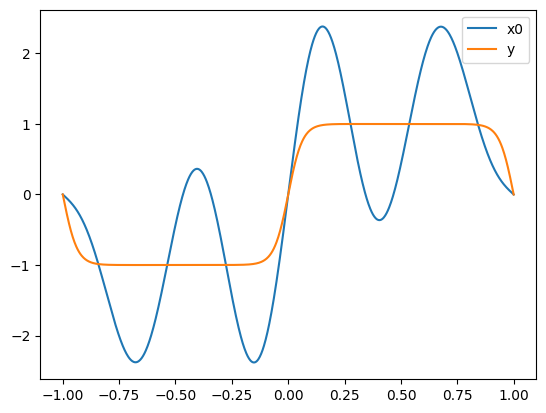

In [10]:
import matplotlib.pyplot as plt
plt.plot(x[:, 1], x[:, 0], label='x0')
plt.plot(x[:, 1], y, label='y')
plt.legend()
plt.show()

In [11]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.3041863691061735  ######### Relative L2 Test Norm: 38.97849013010661
######### Epoch: 1  ######### Train Loss: 0.06348590850830078  ######### Relative L2 Test Norm: 24.92640101114909
######### Epoch: 2  ######### Train Loss: 0.03617081558331847  ######### Relative L2 Test Norm: 16.51577943166097
######### Epoch: 3  ######### Train Loss: 0.016960205510258675  ######### Relative L2 Test Norm: 13.224730936686198
######### Epoch: 4  ######### Train Loss: 0.01366210514679551  ######### Relative L2 Test Norm: 11.714266814125908
######### Epoch: 5  ######### Train Loss: 0.008291583135724067  ######### Relative L2 Test Norm: 10.766489224963719
######### Epoch: 6  ######### Train Loss: 0.007858119462616742  ######### Relative L2 Test Norm: 10.443446058697171
######### Epoch: 7  ######### Train Loss: 0.0076524765696376566  ######### Relative L2 Test Norm: 9.872493807474772
######### Epoch: 8  ######### Train Loss: 0.005044726119376719  ######### Relati

torch.Size([1, 1001, 2])
torch.Size([1, 1001])
torch.Size([1, 1001, 1])
tensor([-1.0000, -0.9980, -0.9960,  ...,  0.9960,  0.9980,  1.0000])
tensor(0.9987, grad_fn=<MeanBackward0>)


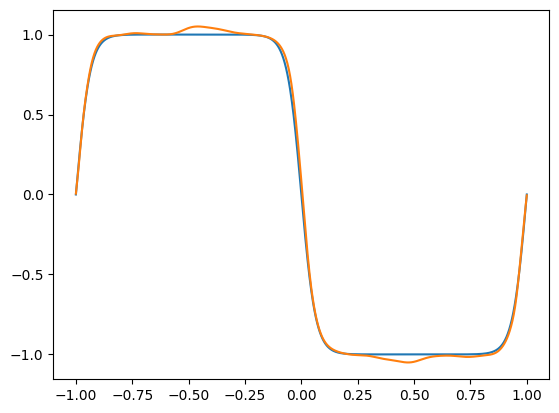

In [12]:
idx_data = 134
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)
print(input_function_test_n.shape)
print(output_function_test_n.shape)

output_function_test_pred_n = fno(input_function_test_n)
print(output_function_test_pred_n.shape)
print(input_function_test_n[0,:,1])
# plt.plot( input_function_test_n[0][:,1] ,input_function_test_n[0][:,0], label = 'x0')
plt.plot( input_function_test_n[0][:,1] ,output_function_test_n.squeeze(0), label = 'y')
plt.plot( input_function_test_n[0][:,1] ,output_function_test_pred_n.squeeze(0).detach().numpy(), label = 'ypred')
print(torch.mean(torch.abs(output_function_test_pred_n.squeeze(0) - output_function_test_n.squeeze(0))))
plt.show()
# plt.figure(dpi=250)
# plt.grid(True, which="both", ls=":")
# plt.plot(input_function_test_n[0,:,1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
# plt.scatter(input_function_test_n[0,:,1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C0")
# p = 2
# err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100
# print("Relative L2 error: ", err.item())
# plt.legend()

In [ ]:
######################### TO DO ####################################
# evaluate drop in performance when the skip connection is removed
# aka the " + conv_layer(x)"
####################################################################